In [1]:
from pandas import read_csv, DataFrame
from rdkit import Chem
from rdkit.Chem import PandasTools, AllChem, rdFingerprintGenerator
from rdkit.Chem import Draw
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from numpy import sqrt, array
import shap
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdCoordGen import AddCoords as addcord
from warnings import filterwarnings
from random import seed
import optuna
import pickle
filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
seed(0)
data = read_csv('../../../DATABASE/no_missing_data.csv')
data

,molecule,smiles,max_abs,max_em,solvent,dc,etn
0,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.0,620.0,DMSO,46.8260,0.444
1,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.0,565.0,H2O,78.3553,1.000
2,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.0,575.0,AcOEt,6.0200,0.228
3,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,450.0,615.0,DCM,8.9300,0.309
4,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.0,615.0,ACN,35.6880,0.460
...,...,...,...,...,...,...,...
696,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,380.0,536.0,DCM,8.9300,0.309
697,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,374.0,549.0,ACN,37.5000,0.460
698,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,376.0,570.0,DIOX,2.2500,0.164
699,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,377.0,560.0,DCM,8.9300,0.309


In [5]:
seed(0)

np.random.seed(0)


PandasTools.AddMoleculeColumnToFrame(data, 'smiles', 'ROMol')
        # Create the fingerprint generator
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 4, fpSize = 2048)

# Generate fingerprints for each molecule
morgan_fps = [list(fp_gen.GetFingerprint(m)) for m in data['ROMol']]

morgan_df = DataFrame(morgan_fps)

morgan_df.columns = ['MF_' + str(j+1) for j in morgan_df.columns]
morgan_df['etn'] = data['etn'].to_numpy()
# morgan['dc'] = data['dc'].values
morgan_df.drop(columns=['MF_1'], inplace=True)
morgan_df

,MF_2,MF_3,MF_4,MF_5,MF_6,MF_7,MF_8,MF_9,MF_10,MF_11,...,MF_2040,MF_2041,MF_2042,MF_2043,MF_2044,MF_2045,MF_2046,MF_2047,MF_2048,etn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.444
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.228
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309
697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.460
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.164
699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.309


In [13]:
seed(0)
np.random.seed(0)
# param_abs = {'n_estimators': 522, 'max_depth': 8, 'learning_rate': 0.028564819211536967, 'subsample': 0.8383756107911184, 'colsample_bytree': 0.720080324874693, 'gamma': 0.001754742159327034, 'reg_alpha': 7.710396015328691e-05, 'reg_lambda': 0.09953515181829936, 'min_child_weight': 4}
# param_em = {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.03275426841763309, 'subsample': 0.7530528560775489, 'colsample_bytree': 0.7318698494144726, 'gamma': 6.127310380299753e-08, 'reg_alpha': 0.4795336721521944, 'reg_lambda': 0.005848556892914068, 'min_child_weight': 3}

model_pred = RandomForestRegressor(n_jobs=-1)

X = morgan_df.to_numpy()
Y = data['max_abs'].to_numpy()
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']


kfold = KFold(n_splits=10, random_state=63, shuffle=True)

In [14]:
seed(0)
np.random.seed(0)
for score in scoring:
    if 'neg' in score:     
        scores = cross_val_score(model_pred, X, Y, cv=kfold, scoring=score)
        if 'squared' in score:
            scores = [sqrt(-x) for x in scores]
        else:
            scores = [-x for x in scores]
        mean_scores = np.mean(scores)
        std_scores = np.std(scores)
        print('{}: {:.4f}+-{:.4f}'.format(score, mean_scores, std_scores))

    else:
        scores = cross_val_score(model_pred, X, Y, cv=kfold, scoring=score)
        print('{}: {:.4f}+-{:.4f}'.format(score, scores.mean(), scores.std()))

r2: 0.8236+-0.0883
neg_mean_squared_error: 20.3960+-7.2395
neg_mean_absolute_error: 9.1924+-1.3356


**For max_abs**

r2: 0.9252+-0.0400

neg_mean_squared_error: 12.0208+-2.8983

neg_mean_absolute_error: 6.8863+-0.8979


**For max_em**

r2: 0.8884+-0.0300

neg_mean_squared_error: 21.6012+-4.0540

neg_mean_absolute_error: 14.9701+-2.2139

In [15]:
seed(0)

model_pred.fit(X, Y)

RandomForestRegressor(n_jobs=-1)

In [16]:
#np.random.seed(0)

error = []

y_preditos = []

for i in range(len(Y)):
    y_expected = Y[i]
    y_pred = model_pred.predict(array(X[i]).reshape(1, -1))

    y_preditos.append(y_pred[0])

    sapato = (abs(y_pred-y_expected)/y_expected)*100

    if sapato > 1 and y_expected > 720:
        print(y_expected)
    error.append(sapato)

782.0


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
import numpy as np
from math import sqrt

residuals = np.abs(Y - np.array(y_preditos))
threshold = 3 * np.std(residuals)
outliers = residuals > threshold

X_clean = X[~outliers]
Y_clean = Y[~outliers]

model_clean = RandomForestRegressor(n_jobs=-1, random_state=42)
kfold_clean = KFold(n_splits=10, random_state=45, shuffle=True)

r2 = []
q2 = []
rmse = []
mae = []

for train_index, test_index in kfold_clean.split(X_clean):
    X_train, X_test = X_clean[train_index], X_clean[test_index]
    Y_train, Y_test = Y_clean[train_index], Y_clean[test_index]
    
    model_clean.fit(X_train, Y_train)
    predictions = model_clean.predict(X_test)

    r2.append(r2_score(Y_test, predictions))
    q2.append(explained_variance_score(Y_test, predictions))
    rmse.append(sqrt(mean_squared_error(Y_test, predictions)))
    mae.append(mean_absolute_error(Y_test, predictions))

print('R2: {:.4f}+-{:.4f}'.format(np.mean(r2), np.std(r2)))
print('Q2: {:.4f}+-{:.4f}'.format(np.mean(q2), np.std(q2)))
print('RMSE: {:.4f}+-{:.4f}'.format(np.mean(rmse), np.std(rmse)))
print('MAE: {:.4f}+-{:.4f}'.format(np.mean(mae), np.std(mae)))


R2: 0.9311+-0.0372
Q2: 0.9315+-0.0374
RMSE: 11.6991+-3.2192
MAE: 6.8529+-1.1824


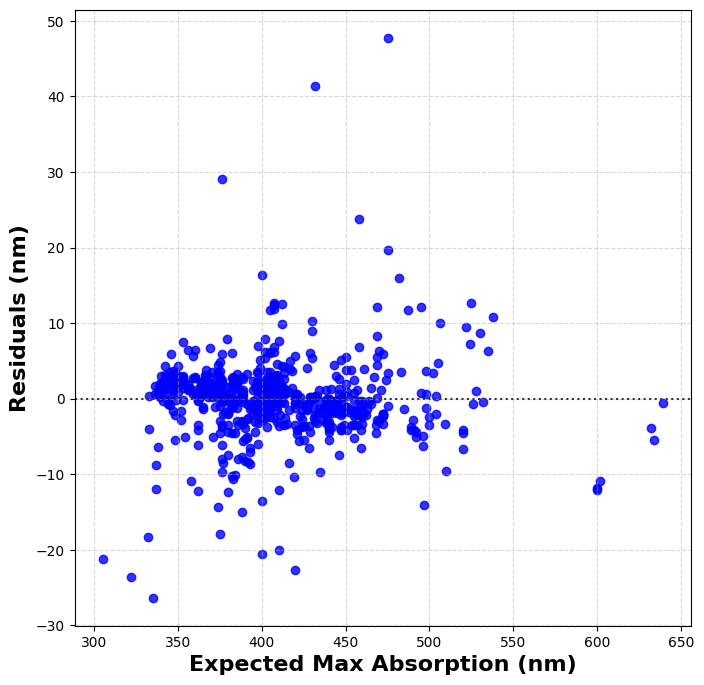

In [18]:
import seaborn as sns

residuals = Y_clean - model_clean.predict(X_clean)

# Create a DataFrame for the residuals
residuals_df = DataFrame({'Expected': Y_clean, 'Residuals': residuals})

fig = plt.figure('residual', figsize=(8,8))
ax = fig.add_subplot(111)

ax.set_box_aspect(1)
sns.residplot(x='Expected', y='Residuals', data=residuals_df, line_kws={'color': 'red', 'linestyle': '--'}, color='#0000FF')
plt.xlabel('Expected Max Absorption (nm)', fontsize=16, fontweight='bold')
plt.ylabel('Residuals (nm)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('Residuals_abs.png', dpi=300)